참고사이트 : https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# 데이터 로더를 위한 데이터 경로 csv파일 만들기.
from pandas import DataFrame, Series
import pandas as pd
import glob
import re
import torchaudio

techniques = ['belt','breathy','lip_trill','vibrato','vocal_fry'] # ['fast_forte','fast_piano', 'forte','inhaled',  'messa','pp','slow_forte','slow_piano','spoken','trill']
train_singers = ['f1','f3','f4','f5','f6','f7','f9',"m1","m2","m4","m6","m7","m8","m9","m11"]
test_singers = ['f2','f8',"m3","m5","m10"]

train_df = pd.DataFrame(columns = {'path','singer','technique', 'length'})
test_df = pd.DataFrame(columns = {'path','singer','technique', 'length'})

# 여기서 train이랑 test나눠서 df 만들기
path = "/content/drive/MyDrive/Startup_Hackathon_Jarvis/data_by_technique/"
for technique in techniques:

  file_list =  glob.glob(path + technique + "/*.wav")

  for i in file_list:
    singer = re.findall(r'[mf][0-9]', i)
    sig, sr = torchaudio.load(i)
    length = sig.shape[1]/sr

    if not len(singer): continue

    if singer[0] in test_singers:
      test_df = test_df.append({'path': i,'singer': singer[0],'technique': technique,'length' : length}, ignore_index = True)
    
    elif singer[0] in train_singers:
      train_df = train_df.append({'path': i,'singer': singer[0],'technique': technique,'length' : length}, ignore_index = True)

train_df.to_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/train_df.csv")
test_df.to_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/test_df.csv")

# 0) EDA

In [ ]:
train_df.head()

,length,technique,singer,path
0,6.617279,belt,f9,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
1,4.958594,belt,f9,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
2,6.157279,belt,f9,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
3,7.021859,belt,f7,/content/drive/MyDrive/Startup_Hackathon_Jarvi...
4,9.040091,belt,f7,/content/drive/MyDrive/Startup_Hackathon_Jarvi...


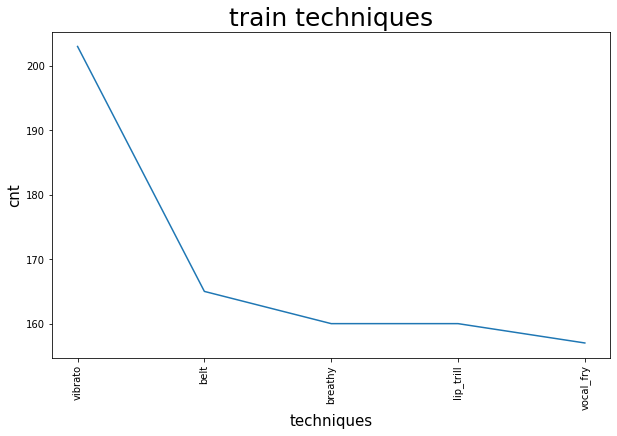

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tmp = train_df["technique"].value_counts()
fig = plt.figure(figsize=(10,6))
plt.plot(tmp)
plt.title("train techniques", fontsize = 25)
plt.xlabel("techniques", fontsize =15)
plt.ylabel("cnt", fontsize = 15)
plt.xticks(rotation = 90)
fig.show()

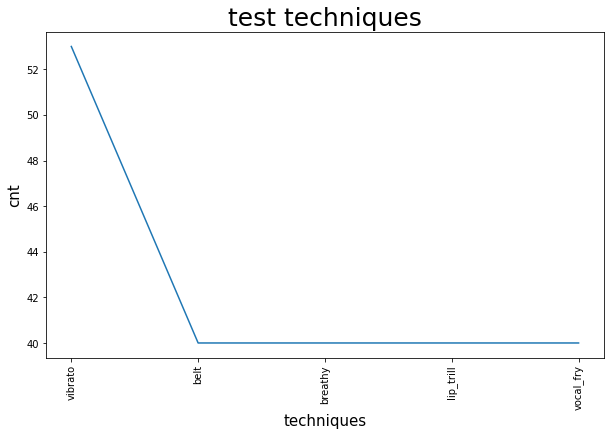

In [ ]:
tmp = test_df["technique"].value_counts()
fig = plt.figure(figsize=(10,6))
plt.plot(tmp)
plt.title("test techniques", fontsize = 25)
plt.xlabel("techniques", fontsize =15)
plt.ylabel("cnt", fontsize = 15)
plt.xticks(rotation = 90)
fig.show()

In [ ]:
train_df['length'].describe()

count    845.000000
mean       9.245670
std        4.960336
min        3.508186
25%        6.682925
50%        8.260816
75%       10.230794
max       48.102449
Name: length, dtype: float64

# 1) Data Util

In [ ]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
plt.style.use('seaborn-white')

In [ ]:
audio = []
indx = []
print('.'+train_df["path"][0])

for i in range(0, 845) :
  x, sr = librosa.load(os.path.join('.', train_df["path"][i]), sr = None, duration = 3.0)
  audio.append(x)
  indx.append(i)


./content/drive/MyDrive/Startup_Hackathon_Jarvis/data_by_technique/belt/f9_scales_belt_o.wav


In [ ]:
import numpy as np

audio_np = np.array(audio, np.float32)
indx_np = np.array(indx, np.int16)

print(audio_np.shape, indx_np.shape)

(845, 132300) (845,)


In [ ]:
import numpy as np

for i in range(0, len(audio_np)) :
  plt.figure(figsize=(18, 2))
  plt.plot(audio_np[i])
  plt.ylim((-0.1, 0.1))
  plt.show()

In [ ]:
print(indx_np[0])
ipd.Audio(audio_np[0], rate=sr)

0


# 2) Data Loader


In [ ]:
import numpy as np

audio_mfcc = []

for x in audio :
  ret = librosa.feature.mfcc(y = x, sr = sr)
  audio_mfcc.append(ret)

for i in range(0, 845) :
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref = np.max)
  librosa.display.specshow(amp_db, sr = sr, x_axis = 'time', y_axis = 'cqt_note')
  plt.colorbar(format = '%+2.0f db')
  plt.title('Spectrogram: {}'.format(indx[i]))
  plt.tight_layout()
  plt.show()

In [ ]:
print(audio_mfcc[1].shape)
print(audio_mfcc[0])

(20, 259)
[[-623.22327   -618.0713    -619.9296    ... -335.78693   -294.8914
  -245.97467  ]
 [  39.221992    45.19217     45.810516  ...   39.13399     67.81808
    91.930626 ]
 [ -18.427393   -12.094896    -4.844233  ...  -92.62099    -90.19353
   -85.99686  ]
 ...
 [  13.901268     7.329757     3.279756  ...   -7.6979866  -23.869783
   -22.754034 ]
 [   7.9361134    6.2337384    6.2151575 ...  -19.720417   -23.667793
   -12.942645 ]
 [   4.41799      3.2356033    3.2448041 ...    5.0396314    6.0998726
    10.857147 ]]


In [ ]:
features = []

for i in range(845) :
  class_label = train_df["technique"][i]
  features.append([audio_mfcc[i], class_label])

featuresdf = pd.DataFrame(features, columns = ['feature', 'class_label'])

featuresdf.head()

In [ ]:
featuresdf.to_pickle("featuresdf.pkl")

In [ ]:
featuresdf = pd.read_pickle("featuresdf.pkl")

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [ ]:
print(len(x_train))
print(len(x_test))
print(x_train.shape)
print(x_test.shape, '\n')
print(y[:200])
print(yy[:10], '\n\n')
print(y_test[:10])

676
169
(676, 20, 259)
(169, 20, 259) 

['belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt' 'belt'
 'belt' 'belt' 'belt' 'belt' 'belt' '

In [ ]:
n_columns = 259  
n_row = 20       
n_channels = 1
n_classes = 5

with tf.device('/cpu:0'):
    x_train = tf.reshape(x_train, [-1, n_row, n_columns, n_channels])
    x_test = tf.reshape(x_test, [-1, n_row, n_columns, n_channels])

In [ ]:
mfcc_np = np.array(audio_mfcc, np.float32)
#mfcc_np = mfcc_np.reshape(845, 20 * 259)
indx_np = np.array(indx, np.int16)

print(mfcc_np.shape, indx_np.shape)

(845, 20, 259) (845,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

# 3) Training

In [ ]:
model = keras.Sequential()

model.add(layers.Conv2D(input_shape=(n_row, n_columns, n_channels), filters=16, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(kernel_size=2, filters=32, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(kernel_size=2, filters=64, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
#model.add(layers.Conv2D(kernel_size=2, filters=128, activation='relu'))
#model.add(layers.MaxPooling2D(pool_size=2))
#model.add(layers.Dropout(0.2))

model.add(layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 19, 258, 16)       80        
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 9, 129, 16)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 9, 129, 16)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 8, 128, 32)        2080      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 4, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 4, 64, 32)        

In [ ]:
training_epochs = 72
num_batch_size = 128

learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=training_epochs)

Epoch 1/72
6/6 [==============================] - 4s 494ms/step - loss: 29.0560 - accuracy: 0.1538
Epoch 2/72
6/6 [==============================] - 4s 574ms/step - loss: 7.2813 - accuracy: 0.2249
Epoch 3/72
6/6 [==============================] - 2s 362ms/step - loss: 8.0682 - accuracy: 0.2544
Epoch 4/72
6/6 [==============================] - 2s 359ms/step - loss: 4.3583 - accuracy: 0.2944
Epoch 5/72
6/6 [==============================] - 2s 343ms/step - loss: 3.5859 - accuracy: 0.2914
Epoch 6/72
6/6 [==============================] - 2s 348ms/step - loss: 2.8866 - accuracy: 0.3180
Epoch 7/72
6/6 [==============================] - 3s 523ms/step - loss: 2.4380 - accuracy: 0.3299
Epoch 8/72
6/6 [==============================] - 3s 520ms/step - loss: 2.1388 - accuracy: 0.3757
Epoch 9/72
6/6 [==============================] - 2s 325ms/step - loss: 1.8850 - accuracy: 0.4127
Epoch 10/72
6/6 [==============================] - 2s 325ms/step - loss: 1.7995 - accuracy: 0.4246
Epoch 11/72
6/6 [=

In [ ]:
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

mfcc_array = np.expand_dims(mfcc_np, -1)
indx_cat = to_categorical(indx_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, indx_np, test_size = 0.1)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(760, 20, 259, 1)
(85, 20, 259, 1)
(760,)
(85,)


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model = Sequential()

  input = Input(shape = (20, 259, 1))

  output = Conv2D(128, 3, strides = 1, padding = 'same', activation = 'relu')(input)
  output = MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same')(output)

  output = Conv2D(256, 3, strides = 1, padding = 'same', activation = 'relu')(output)
  output = MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same')(output)

  output = Conv2D(512, 3, strides = 1, padding = 'same', activation = 'relu')(output)
  output = MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same')(output)

  output = Flatten()(output)
  output = Dense(512, activation = 'relu')(output)
  output = Dense(256, activation = 'relu')(output)
  output = Dense(128, activation = 'relu')(output)

  output = Dense(1, activation = 'softmax')(output)

  model = Model(inputs = [input], outputs = output)

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

  return model

# 4) Test

In [ ]:
print('Test Data Evaluation')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

print

Test Data Evaluation
2/2 [==============================] - 0s 36ms/step - loss: 1.1950 - accuracy: 0.4911
test loss, test acc: [1.1949710845947266, 0.4911242723464966]


# 5) Evaluation

TypeError: ignored

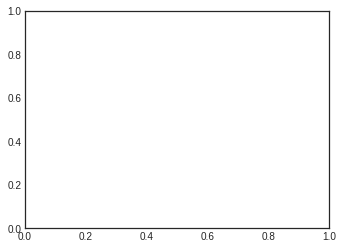

In [ ]:
import matplotlib.pyplot as plt
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()
    
plot_history(history)

In [ ]:
model.save("sound_classifier_model")

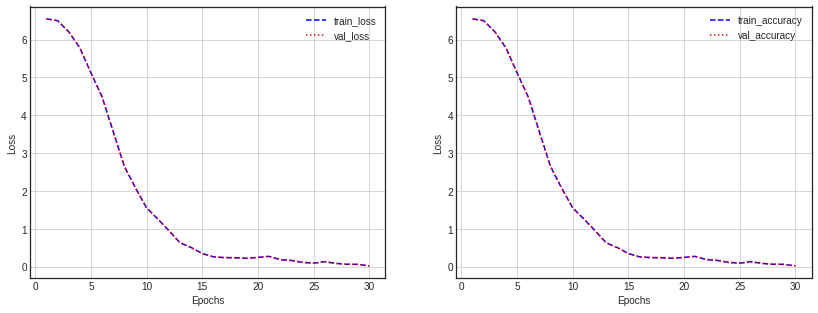

In [ ]:
def plot_history(history_dict) :
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize = (14, 5))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, loss, 'b--', label = 'train_loss')
  ax1.plot(epochs, loss, 'r:', label = 'val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, loss, 'b--', label = 'train_accuracy')
  ax2.plot(epochs, loss, 'r:', label = 'val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()


plot_history(history.history)